# Climatologia Mensal de Precipitação do Brasil

### calcular a climatologia Mensal de chuva para o período 1991-2020 do ERA5

###  Importar as bibliotecas

In [1]:
import xarray as xr
import numpy as np
import geopandas as gpd
import regionmask as rmk
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

C:\Users\igf_i\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [ ]:
import calendar

### Carregar os dados (dataset)

In [2]:
path_ERA5 = 'Dados_ERA5/ERA5_Prec_Month_BR_1991-2023.nc'
path_shape_BR = 'Brasil_Contorno/Brasil.shp'
path_out = 'Figuras/'

In [3]:
# Carregar o arquivo .nc e verificar os metadados
df = xr.load_dataset(path_ERA5) 

In [ ]:
#ds_ERA5.time.dt.dayofyear
#ds_ERA5.time.dt.month
# ds_ERA5.time.dt.day
# ds_ERA5.time.dt.year
# ds_ERA5.time.dt.season

### Selecionar o período e domínio espacial

In [5]:
df_BR_clim = df.sel(time = slice('1991', '2020')).sel(latitude = slice(6, -36), longitude = slice(-77, -33))

df_BR_clim

<xarray.Dataset>
Dimensions:    (time: 360, longitude: 169, latitude: 165)
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01 1991-02-01 ... 2020-12-01
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -33.5 -33.25 -33.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -34.5 -34.75 -35.0
Data variables:
    tp         (time, latitude, longitude) float32 0.006318 0.003268 ... 0.00522
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Apr 08 08:45:59 2024: cdo -v -z zip -sellonlatbox,-75,-...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

### Calcular a climatologia mensal para 1991-2020

In [6]:
# Converter a unidade de precipitação para mm/mês (uma vez que o dado é mensal)
# para passar para mm/mês multiplique pela quantidade de dias para cada mês usando a função .time.dt.daysinmonth
df_BR_clim = df_BR_clim * 1000 * df_BR_clim.time.dt.daysinmonth #mm/mês

# Calcular a climatologia anual (mm/mês), multiplica por 12 para passar de mm/mês para mm/ano
df_BR_clim = df_BR_clim.groupby('time.month').mean(dim = 'time') #cálculo da climatologia mensal


### Selecionar a variável chuva do dataset

In [7]:
prec_clim = df_BR_clim['tp']

prec_clim

<xarray.DataArray 'tp' (month: 12, latitude: 165, longitude: 169)>
array([[[155.32227661,  93.34764077,  59.60109172, ..., 110.19138604,
         108.73146153, 109.63189027],
        [105.56686403,  66.02652197,  62.97991505, ..., 131.05431053,
         128.59343489, 127.91811483],
        [ 97.57879854,  73.56219962,  79.00629186, ..., 156.8717896 ,
         156.7297563 , 157.20838401],
        ...,
        [  4.00381486,   3.24105844,   2.92417804, ..., 168.39601334,
         170.75635575, 172.18786609],
        [  4.01912034,   3.23668544,   3.14491416, ..., 166.0662602 ,
         167.58737701, 169.60678405],
        [  4.13492769,   3.16895023,   3.22795485, ..., 161.97934713,
         163.22508159, 164.69158967]],

       [[152.64014986, 100.00484085,  67.45564723, ...,  31.66672662,
          32.17826075,  35.1823052 ],
        [ 97.11625239,  77.38746617,  85.29119575, ...,  38.33612716,
          38.91797009,  40.33263855],
        [ 89.10469414,  85.76940648, 118.21498781, ...,  53.81140138,
          53.33395879,  53.7452741 ],
...
        [  8.11734796,   7.26713985,   7.15503842, ..., 144.23542833,
         142.93047476, 140.88738751],
        [  8.65671784,   7.79376179,   7.79587775, ..., 146.28277349,
         146.65502262, 142.96008694],
        [  9.23411548,   8.34789872,   8.34367424, ..., 144.91014194,
         147.02937078, 145.34581852]],

       [[257.23718742, 147.47625884,  87.88822081, ..., 344.48510532,
         346.47390633, 343.08199654],
        [188.40001797, 113.31230774, 102.66010516, ..., 370.30038423,
         373.12845889, 370.70034492],
        [171.72456196, 126.15438597, 118.12262491, ..., 407.79290255,
         407.4760115 , 405.8281227 ],
        ...,
        [  6.58271114,   5.97733632,   5.82434312, ..., 152.6100534 ,
         153.74433059, 154.74966863],
        [  7.01107979,   6.42098735,   6.04507153, ..., 149.50005058,
         148.72639155, 148.96243049],
        [  7.29955882,   6.15217139,   6.08221889, ..., 146.8402693 ,
         144.94543063, 144.49305634]]])
Coordinates:
  * longitude  (longitude) float32 -75.0 -74.75 -74.5 ... -33.5 -33.25 -33.0
  * latitude   (latitude) float32 6.0 5.75 5.5 5.25 ... -34.5 -34.75 -35.0
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### Mascarar a região desejada

In [9]:
BR_shp = gpd.read_file(path_shape_BR)

In [10]:
mask_BR = rmk.from_geopandas(BR_shp)   

In [11]:
prec_clim = prec_clim.rename({'latitude': 'lat', 'longitude': 'lon'})

prec_clim_mask = mask_BR.mask(prec_clim)

prec_clim_mask_BR = prec_clim.where(prec_clim_mask == 0)

### Plotar as climatologias mensais em forma de mapas como subplots em apenas 1 figura

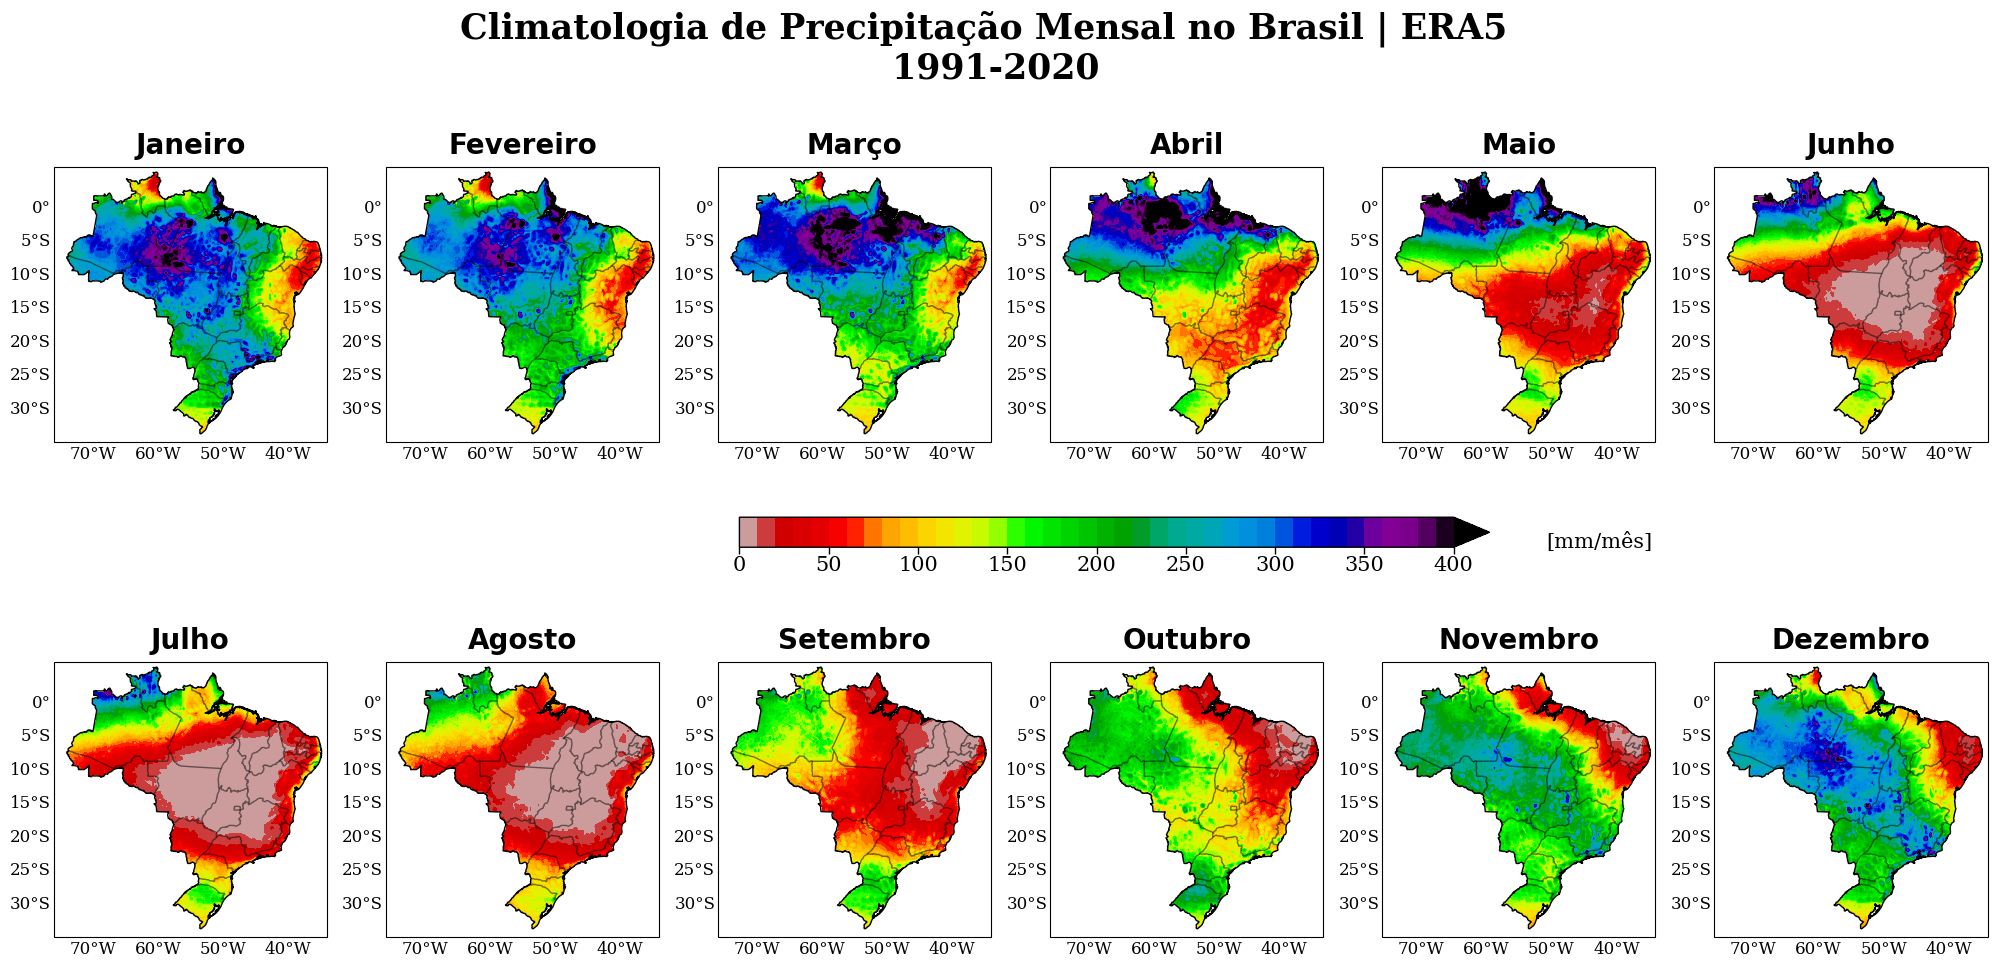

In [12]:
mon_list_name = ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']

fig, axs = plt.subplots(2, 6, figsize = (25, 10), subplot_kw = dict(projection = ccrs.PlateCarree()))

axs_list = axs.ravel()

font_gl = {'size': 12,'color': 'black'}

plt.rcParams['font.family'] = 'serif'

states = NaturalEarthFeature(category = 'cultural', scale = '50m', facecolor = 'none', name ='admin_1_states_provinces_lines')

for i in range(12):

    plot_clim = axs_list[i].contourf(prec_clim_mask_BR.lon, prec_clim_mask_BR.lat, prec_clim_mask_BR[i], transform = ccrs.PlateCarree(),
                                    cmap = 'nipy_spectral_r', levels = np.arange(0, 410, 10), extend = 'max')

    axs_list[i].add_feature(states, edgecolor = 'black', linewidth = 1, alpha = 0.5, linestyle = '-')
    
    axs_list[i].set_xlim(left = -76, right = -34)
    axs_list[i].set_ylim(bottom = -35, top = 6)

    gl = axs_list[i].gridlines(crs = ccrs.PlateCarree(), draw_labels = True, alpha = 0)
    gl.top_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.right_labels = False
    gl.xpadding = 2
    gl.ypadding = 2
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mticker.FixedLocator(np.arange(-70, -30, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-30, 5, 5))
    gl.xlabel_style = font_gl
    gl.ylabel_style = font_gl

    BR_shp.plot(ax = axs_list[i], lw = 1, ec = 'black', fc = 'none')
    
    #mon_name = calendar.month_name[i + 1]
    mon_name = mon_list_name[i]
    
    axs_list[i].set_title(mon_name, fontsize = 20, fontweight = 'bold', pad = 10)

    
cbar_ax = fig.add_axes([0.4, 0.5, 0.3, 0.03])
cbar = plt.colorbar(plot_clim, cax = cbar_ax, orientation = 'horizontal')
cbar.outline.set_linewidth(1)
cbar.ax.tick_params(labelsize = 15, width = 1, length = 5, pad = 1)

axs_list[0].text(5.66, -0.36, '[mm/mês]',
                  verticalalignment = 'center', horizontalalignment = 'center',
                  transform = axs_list[0].transAxes,
                  color = 'black', fontsize = 15,
                  fontweight = 'normal')

fig.suptitle('Climatologia de Precipitação Mensal no Brasil | ERA5 \n 1991-2020',
                x = 0.5, y = 1, ha = 'center', va = 'center', fontsize = 25, fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.8)

plt.savefig(f'{path_out}Clima_Chuva_Mensal_1991-2020_ERA5.jpeg', dpi = 600, bbox_inches = 'tight')